# Housing Prices Model

### Graeme Keleher 20190722

<p><a name="sections"></a></p>

## Sections

* [Load Packages](#1)
* [Import Data](#2)
* [Transform Target Variable](#3)
* [Seperate into Numeric and Categorical Features](#4)
* [Deal with Missing Categorical Data](#5)
* [Deal with Missing Numeric Data](#6)
* [Combine Feature Types, Dummify and Split](#7)
* [Baseline RandomForest Model](#8)


## Load Packages <a id="1"></a>

In [1]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
#from sklearn.model_selection import RepeatedKFold
import matplotlib.pyplot as plt
import math
from sklearn.model_selection import GridSearchCV

## Import Data <a id="2"></a>

Import training and test data from their respective files. 

In [2]:
#Load training data
X_train = pd.read_csv('train.csv', index_col = 'Id')

#load training data
X_test = pd.read_csv('test.csv', index_col = 'Id')


## Drop Outliers <a id="20"></a>

Drop outliers from training data then combine with test for processing

In [3]:
X_train = X_train.drop(X_train[(X_train['GrLivArea']>4000) & (X_train['SalePrice']<300000)].index)

#set target feature to y
y = X_train['SalePrice']

# drop target feature from training data
X_train.drop('SalePrice',axis=1,inplace=True)

#store end of training data index for future splitting
end_train_index = X_train.shape[0]

#Combine test and training predictive features for preprocessing
X = pd.concat([X_train,X_test])

## Transform Target Variable <a id="3"></a>

The distribution of sale prices is highly skewed. This transformation brings it closer to a normal distribution. 

In [4]:

y_log = y.apply(math.log)


## Seperate Into Numeric and Categorical Features <a id="4"></a>

This is needed because the way we will deal with missing data depends on the type of feature. 


In [5]:
# list of all training features
X_all_feature_names = X.columns.tolist()

# data frame of just numeric training data, note that MSSubClass is 
#also dropped becuase it is actually categorical
X_numeric_features = X._get_numeric_data().drop('MSSubClass',axis=1)

# list of only numeric training data features
X_numeric_feature_names = X_numeric_features.columns.tolist()

# list of only categoric training data features
X_categoric_feature_names = list(set(X_all_feature_names)-set(X_numeric_feature_names))

# categoric data
X_categoric_features = X[X_categoric_feature_names]

## Deal With Missing Categorical Data <a id="5"></a>

Here we replace all instances of 'nan' with 'Missing' then convert the data type to category.

In [6]:
X_categoric_features.fillna('Missing', inplace = True)
    
    
for name in X_categoric_feature_names:
    X_categoric_features[name] = X_categoric_features[name].astype('category')

C:\Users\gakel\Anaconda3\lib\site-packages\pandas\core\frame.py:4034: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)
C:\Users\gakel\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


## Deal With Missing Numeric Data <a id="6"></a>

Here we replace all instances of 'nan' with 0 then create dummy variables for all numeric data with a zero. 

In [7]:
X_numeric_features.fillna(0, inplace = True)


for name in X_numeric_feature_names:
    new_name = name + "_is_Zero"
    
    X_numeric_features[new_name] = X_numeric_features[name].apply(lambda x: "Zero" if x == 0 else "Non_Zero").astype('category')

## Feature Engineering

Total square footage of home could prove predictive
transform year built to age

In [8]:
X_numeric_features['TotalSF'] = X_numeric_features['TotalBsmtSF'] + X_numeric_features['1stFlrSF'] + X_numeric_features['2ndFlrSF']

X_numeric_features['HomeAge'] = X_numeric_features['YearBuilt'].max() - X_numeric_features['YearBuilt']

## Combine Feature Types, Dummify and Split <a id="7"></a>

In [9]:
X_processed = X_numeric_features.join(X_categoric_features,how = 'inner')
   
X_processed = pd.get_dummies(X_processed)

X_train_processed = X_processed[:end_train_index]

X_test_processed = X_processed[end_train_index:]

## Baseline RandomForest Model <a id="8"></a>

explore concentrate on max features, sqrt(d) a decent rule but will affect a lot
for n_estimators more is better but takes more time
for max_depth, the larger this number the more likely it overfits

decent results
{'max_depth': 9, 'n_estimators': 20}
better
{'max_depth': 50, 'n_estimators': 1000}
more better
{'max_depth': 40, 'max_features': 50, 'n_estimators': 500}
Even better
{'max_depth': 40, 'max_features': 70, 'n_estimators': 1000}

In [ ]:
#Define model
rfr = RandomForestRegressor()

#Define hyperparameter tune grid
param_grid = {
                 'n_estimators': [1000],
                 'max_depth': [30,40,50],
                 'max_features' : [70,100,130,150]
             }
'''
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}
'''
#define grid search object
grid_rfr = GridSearchCV(rfr, param_grid, cv=10)

#Search for best model with 10 fold CV
grid_rfr.fit(X_train_processed,y_log)

#define best model
best_model = grid_rfr.best_estimator_

#make predictions on test data with best model
y_hat = best_model.predict(X_test_processed)

#create data frame of results
test_result = pd.DataFrame({'Id':X_test_processed.index, 'SalePrice' : y_hat})

#Transform predicted values back from log values
test_result['SalePrice'] = test_result['SalePrice'] .apply(math.exp)

#Save to csv file in submission format
test_result.to_csv('graeme_housing_submissing.csv',index=False)

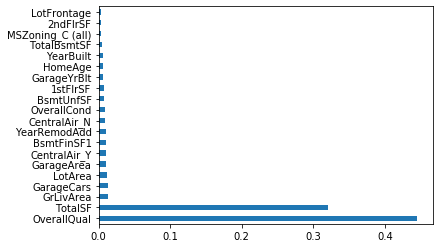

In [14]:
feat_importances = pd.Series(best_model.feature_importances_, index=X_test_processed.columns)
feat_importances.nlargest(20).plot(kind='barh')

In [19]:
grid_rfr.best_params_


{'max_depth': 40, 'max_features': 70, 'n_estimators': 1000}

In [ ]:
X_train.plot.scatter(x = "", y = "")